## Use `Ocetrac` to identify and track marine heatwave (MHW) objects 

![fig](../static/ocetrac_steps.png)


In [1]:
# Import libraries 
import xarray as xr
import numpy as np
import ocetrac

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Import the preprocessed OISST dataset

The data are available on Zenodo.

In [2]:
path_to_data = '../preprocessed_oisst_mhw_stats.nc'
ds = xr.open_dataset(path_to_data)
ds

<xarray.Dataset>
Dimensions:        (time: 478, lat: 720, lon: 1440)
Coordinates:
  * lon            (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
Data variables:
    mean           (time, lat, lon) float64 ...
    trend          (time, lat, lon) float64 ...
    seas           (time, lat, lon) float64 ...
    ssta_notrend   (time, lat, lon) float64 ...
    avg_duration   (lat, lon) float64 ...
    avg_count      (lat, lon) float64 ...
    avg_intensity  (lat, lon) float64 ...
Attributes:
    description:  OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

### Import the land mask for the OISST dataset and mask out both poles

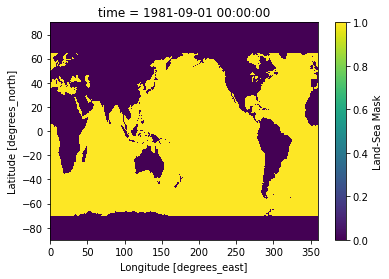

In [3]:
path = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/lsmask.oisst.nc'
ds_mask = xr.open_dataset(path, use_cftime=True) 
lsmask = ds_mask.lsmask.isel(time=0)
mask = lsmask.where((ds_mask.lat<65) & (ds_mask.lat>-70), drop=False, other=0) 
mask.plot()

## Run Ocetrac

In [4]:
# Calculate the 90th percentile of anomalies across the entire time period
t90_global = ds.ssta_notrend.quantile(.9)

# Find only the sst anomalies that exceed the local 90th percentile
da = ds.ssta_notrend.where(ds.ssta_notrend>t90_global, drop=False, other=np.nan)

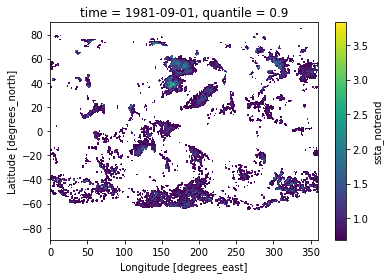

In [5]:
da[0,:,:].plot()

In [6]:
#### Set model parameters

da.load(); # load the DataArray into memory
radius = 8 # radius for structuring element
min_size_quartile = 0.75 # threshold for object areas
timedim = 'time'
xdim = 'lon'
ydim = 'lat'

In [7]:
Tracker =  ocetrac.Tracker(da, mask, radius, min_size_quartile, timedim, xdim, ydim, positive=True)

In [8]:
%%time 
blobs = Tracker.track()

minimum area: 2485.5
inital objects identified 	 13862
final objects tracked 	 686
CPU times: user 9min 53s, sys: 1min 54s, total: 11min 47s
Wall time: 11min 55s


**The basic output of `Tracker.track` provides:**
- the minimum object area used to filter out MHWs that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MHW objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MHW objects tracked in space and time. 

#### Make some quick plot to check resulting data

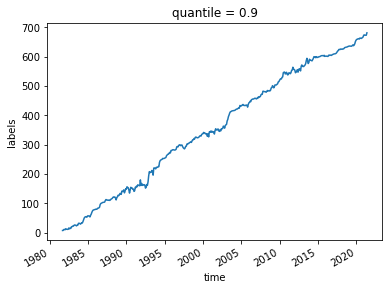

In [9]:
# Event label over time
blobs.mean(('lat','lon')).plot()

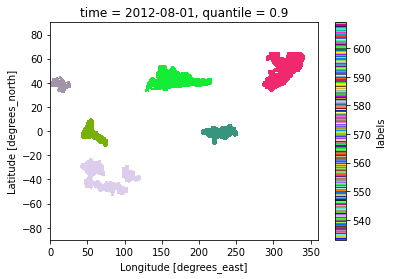

In [10]:
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


# Make a quick plot of the labeled MHWs identified with Ocetrac in August 2012
blobs.sel(time=('2012-08-01')).plot(cmap= cm)

#### Save labeled marine heatwave images

In [11]:
# Specify path to save output 
new_data_path = '../data/ocetrac_labels.nc'

ds_out = blobs.to_dataset(name='ocetrac_labels')
ds_out.attrs = dict(description="OISST v2.1 preprocessed for Ocetrac",
                    threshold='90th percentile',
                    climatology='entire period')

# Save Dataset to netCDF
ds_out.to_netcdf(new_data_path, mode='w')
